## QuasarNET Performance vs nchunks
#### Plot to show performance of QuasarNET as a function of the number of boxes/chunks
xxx

In [1]:
import astropy
import copy
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [3]:
## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [7]:
data = {}

for oaf in variables.OFFSET_ACT_FNS:
        
    ## Load the QN using OAF value.
    f_qn = variables.OUTDIR+'/outputs/qn_outputs/additional_setups/offset_act/{}/qnAll-train_0.1_coadd_0_0_oaf{}-test_coadd.fits'.format(oaf,oaf)
    data['QN_{}'.format(oaf)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_paper//outputs/qn_outputs/additional_setups/offset_act/rescaled_sigmoid/qnAll-train_0.1_coadd_0_0_oafrescaled_sigmoid-test_coadd.fits'

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=False)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_sigmoid,CLASS_QN_sigmoid,ISQSO_QN_sigmoid,C_QN_sigmoid [6],Z_QN_linear,CLASS_QN_linear,ISQSO_QN_linear,C_QN_linear [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,str8,bool,float64
7166566020362,20589337,2,1.616,QSO,True,1.622,QSO,True,0.000 .. 0.003,1.625,QSO,True,0.000 .. 0.000
7166566020367,20603085,2,2.070,QSO,True,2.084,QSO,True,1.000 .. 0.000,2.057,QSO,True,1.000 .. 0.000
7169566280047,20935261,2,0.000,STAR,False,3.836,NONQSO,False,0.000 .. 0.000,2.415,NONQSO,False,0.000 .. 0.000
7169566280046,20935742,2,0.000,STAR,False,0.464,NONQSO,False,0.000 .. 0.000,1.446,NONQSO,False,0.000 .. 0.000
7169566280052,20936956,2,0.000,STAR,False,3.015,NONQSO,False,0.000 .. 0.000,2.102,NONQSO,False,0.000 .. 0.000


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

506016

### Compare the performance of the different model/data combos.
xxx

In [8]:
ls = {'QN_rescaled sigmoid': '-',
      'QN_sigmoid': '--',
      'QN_linear': '-.',
     }

In [9]:
## Define general parameter values.
dv_max = 6000.

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 100
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [10]:
## Define strategies.
strategies = {}

for s in data.keys():
    
    oaf = (s.split('_')[-1])
    name = oaf
    if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
        filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
    else:
        filt = np.ones(len(data_table)).astype(bool)
    
    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(data_table,filter=filt,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'isqso': [pred.isqso for pred in preds],
                     'z': [pred.z for pred in preds],
                     'c_th': c_th_values,
                     'n': name, 
                     'ls': ls[s]}

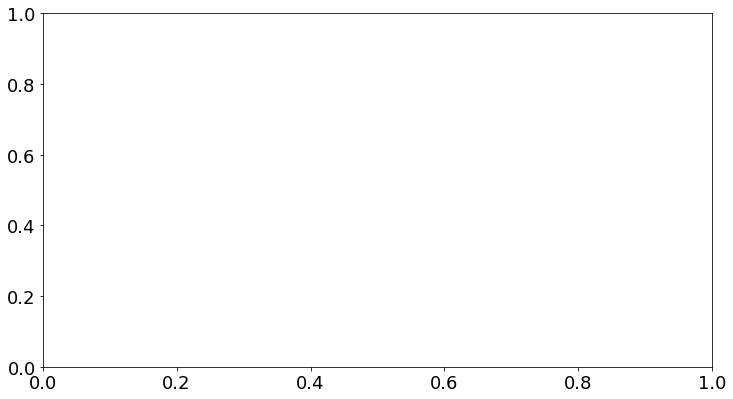

In [11]:
filename = '../plots/qn_performance_vs_oaf.pdf'

fig, axs = plt.subplots(1,1,figsize=figsize,squeeze=False)


plt.show()